## Atomic systems (Netket)
Figuring out how to represent and optimize for ground states of atomic systems

In [397]:
# Can start with simple ansatz, just get the Hamiltonian right, and the fermion - boson stuff
import netket as nk
import netket.experimental as nkx
import jax.numpy as jnp

In [398]:
# Hydrogen - 1 electron in atomic units
N = 1
#geo = nkx.geometry.FreeSpace(d=3)
hi = nk.hilbert.Particle(N=N, D=3, pbc=False)

In [432]:
ekin = nk.operator.KineticEnergy(hi, mass=1.0)

def v(x):
    # electron nuclear, electron electron, nuclear nuclear
    return - 1/(jnp.linalg.norm(x))  # Centred at (0,0)

pot = nk.operator.PotentialEnergy(hi, v)

ha = ekin + pot

In [433]:
# Define Ansatz with two parameters - controlling Gaussian and the scaling

import flax.linen as nn
from flax import nnx
import jax
from flax.linen.dtypes import promote_dtype
from flax.linen.initializers import normal

from netket.utils.types import DType, Array, NNInitFunc

DType = jnp.float64


class Jastrow(nnx.Module):

    def __init__(self, *, rngs: nnx.Rngs):
        self.j1 = nnx.Param(0.1 * jax.random.normal(rngs.params(), (1,)), dtype=complex)
        self.j2 = nnx.Param(0.1 * jax.random.normal(rngs.params(), (1,)), dtype=complex)

    def __call__(self, x: jax.Array):
        # NN correlation
        norm_x = jnp.linalg.norm(x, axis=1)
        return jnp.exp(- self.j1 * norm_x) * self.j2 * norm_x

In [485]:
### Neural Network Quantum State

class FFN(nnx.Module):
    def __init__(self, N: int, alpha:int = 3, *, rngs: nnx.Rngs):
        self.alpha = alpha
        self.linear = nnx.Linear(in_features=N, out_features = alpha * N, rngs=rngs,
                                  param_dtype=jnp.float64, dtype=jnp.float64)
        self.j1 = nnx.Param(jax.random.normal(rngs.params(), (1,)), dtype=jnp.float64)
        self.j2 = nnx.Param(jax.random.normal(rngs.params(), (1,)), dtype=jnp.float64)

    def __call__(self, x: jax.Array):
        norm_x = jnp.linalg.norm(x, axis=1)
        y = self.linear(norm_x.reshape(norm_x.shape[0], 1))
        y = nnx.relu(y) # max(0, X)
        return jnp.sum(y, axis=-1)

In [486]:
jas_model = Jastrow(rngs=nnx.Rngs(0))

In [487]:
ffn_model = FFN(N=1, rngs=nnx.Rngs(0))

In [488]:
ffn_model

FFN( # Param: 8 (64 B)
  alpha=3,
  linear=Linear( # Param: 6 (48 B)
    kernel=Param( # 3 (24 B)
      value=Array(shape=(1, 3), dtype=dtype('float64'))
    ),
    bias=Param( # 3 (24 B)
      value=Array(shape=(3,), dtype=dtype('float64'))
    ),
    in_features=1,
    out_features=3,
    use_bias=True,
    dtype=float64,
    param_dtype=float64,
    precision=None,
    kernel_init=<function variance_scaling.<locals>.init at 0x000001DE563DD1B0>,
    bias_init=<function zeros at 0x000001DE5450E200>,
    dot_general=<function dot_general at 0x000001DE53FBFF40>,
    promote_dtype=<function promote_dtype at 0x000001DE563DCDC0>
  ),
  j1=Param( # 1 (8 B)
    value=Array([0.39051537], dtype=float64),
    dtype="<class 'jax.numpy.float64'>"
  ),
  j2=Param( # 1 (8 B)
    value=Array([0.67628103], dtype=float64),
    dtype="<class 'jax.numpy.float64'>"
  )
)

In [489]:
sa = nk.sampler.MetropolisGaussian(hi, sigma=0.01, n_chains=16, sweep_size=32)
vstate = nk.vqs.MCState(sa, ffn_model, n_samples=512)

In [490]:
vstate.init_parameters()
optimizer = nk.optimizer.Adam(
    learning_rate=0.01)

gs = nk.driver.VMC(
    ha, optimizer, variational_state=vstate,
    preconditioner=nk.optimizer.SR(diag_shift=0.01),)


log = nk.logging.RuntimeLog()

vstate.expect_and_grad(ha)

(-0.676 ± 0.015 [σ²=0.121, R̂=1.3880],
 {'j1': Array([0.], dtype=float64),
  'j2': Array([0.], dtype=float64),
  'linear': {'bias': Array([ 2.80621107e-01,  1.31838984e-16, -2.07351727e-01], dtype=float64),
   'kernel': Array([[ 0.67486079,  0.44721194, -0.14791515]], dtype=float64)}})

Either their sampling is wrong, or they're doing something really smart. There's no burn in, no adjusted step. They don't seem to track the Xs correctly. Something to discuss with the group.
The CQSL group implemented a Metropolis Gauss Adaptive - harmonic_interaction.py - https://github.com/cqsl/electron-tvmc/blob/main/harmonic_interaction.py. They probably have their own way of doing burn-in. These guys are not geniuses at continuous systems.

In [491]:
log = gs.run(n_iter=10000, out=log)

100%|██████████| 10000/10000 [01:33<00:00, 107.39it/s, Energy=-5.000e-01 ± 9.697e-18 [σ²=4.815e-32, R̂=1.1648]]  


In [493]:
log['Energy']

TypeError: tuple indices must be integers or slices, not str

In [495]:
log[0]

RuntimeLog():
 keys = ['acceptance', 'Energy']

Text(0.5, 1.0, 'Jastrow Ansatz')

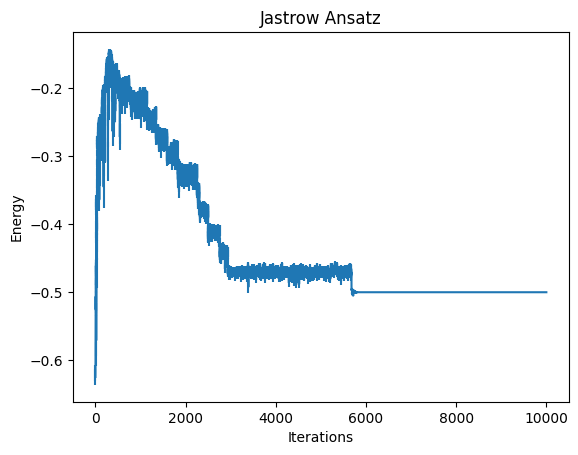

In [496]:
import matplotlib.pyplot as plt
data_jastrow = log[0]
plt.errorbar(
    data_jastrow["Energy"].iters,
    data_jastrow["Energy"].Mean,
    yerr=data_jastrow["Energy"].Sigma,
)


plt.xlabel("Iterations")
plt.ylabel("Energy")
plt.title("Jastrow Ansatz")

In [389]:
# just have a ham_t that takes t as an additional parameter and creates that td E field. Let's see what happens here directly
def Esin(x, t=0, w=1.0, Eo=2.0):
    return Eo * jnp.sin(w * t) * jnp.dot(jnp.array([0, 0, 1.0]), x)

In [390]:
Es = [Esin(jnp.array([1.0, 1.0, 1.0]), t=0.01 * T) for T in range(0,1000)]

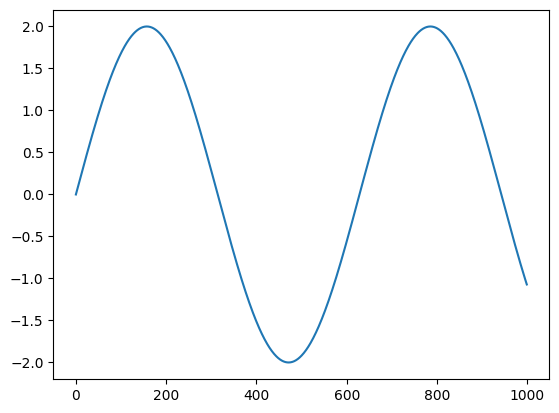

In [391]:
plt.plot(Es)

In [392]:
vp = pot = nk.operator.PotentialEnergy(hi, Esin)

In [395]:
ha_t = lambda t: ha + vp

### Dynamics
integrator = nkx.dynamics.Heun(dt=0.05)
qgt = nk.optimizer.qgt.QGTJacobianDense(holomorphic=False)
te = nkx.TDVP(ha_t, vstate, integrator, qgt=qgt)
log = nk.logging.RuntimeLog()
obs = {"E": ha}
te.run(T=100.0, out=log, obs=obs)

 46%|████▋     | 46.5/100 [00:21<00:25, 2.13it/s, n=929, Generator=-0.501126 ± 0.000070 [σ²=0.000003, R̂=1.3523]]


KeyboardInterrupt: 

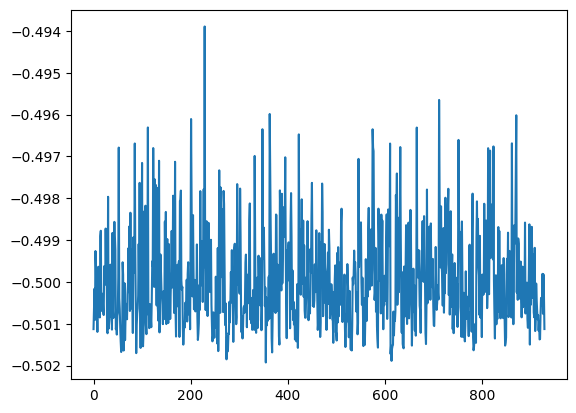

In [396]:
plt.plot(log['E']['Mean'])